In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from scipy.stats import zscore

### Load Data (Subject 1)

In [2]:
# Directories
dir_data = 'data'
dir_resp = os.path.join(dir_data, 'respiration')
dir_ebit = os.path.join(dir_data, 'emotibit')

In [3]:
# Load in Repsiration Data
respiration_fp = os.path.join(dir_resp, 'digital_twin_vernier_sub1.csv')
respiration_df = pd.read_csv(respiration_fp)
respiration_df['timestamp'] = pd.to_datetime(respiration_df['timestamp'])
respiration_df['elapsed_time'] = (respiration_df['timestamp'] -respiration_df['timestamp'][0]).dt.total_seconds()
respiration_df['force'] = pd.to_numeric(respiration_df['force'], errors='coerce')
respiration_df['force_z'] = zscore(respiration_df['force'].dropna())

# Load in HR Data
emotibit_fp = os.path.join(dir_ebit, 'digital_twin_emotibitgt_sub1.csv')
# Truncate rows to 7 columns (only 7 necessary for HR, BI, EA)
with open(emotibit_fp, newline='') as f:
    reader = csv.reader(f)
    truncated_data = [row[:7] for row in reader]
temp_df = pd.DataFrame(truncated_data)
temp_df.columns = ['LocalTimestamp', '-','DataLength', 'TypeTag', 'ProtocolVersion', 'DataReliability', 'Value']
temp_df['Value'] = pd.to_numeric(temp_df['Value'], errors='coerce')
temp_df['LocalTimestamp'] = pd.to_numeric(temp_df['LocalTimestamp'], errors='coerce')

ba = temp_df['TypeTag'] == 'HR'
hr_df = temp_df.loc[ba,:].reset_index(drop=True)
hr_df['hr_z'] = zscore(hr_df['Value'].dropna())

# Load in EDA Data
ba = temp_df['TypeTag'] == 'EA'
eda_df = temp_df.loc[ba,:].reset_index(drop=True)
eda_df['eda_z'] = zscore(eda_df['Value'].dropna())

# Load in BI & convert to HRV
ba = temp_df['TypeTag'] == 'BI'
bi_df = temp_df.loc[ba,:].reset_index(drop=True)

In [4]:
# Calculate HRV
# RMSSD function
def compute_rmssd(bi_values):
    diff = np.diff(bi_values)
    return np.sqrt(np.mean(diff**2)) if len(diff) > 0 else np.nan

# Apply a moving window
window_size = 5
hrv_values = []
timestamps = []

for i in range(window_size, len(bi_df)):
    window = bi_df['Value'].iloc[i-window_size:i].values
    rmssd = compute_rmssd(window)
    hrv_values.append(rmssd)
    timestamps.append(bi_df['LocalTimestamp'].iloc[i])

# HRV dataframe
hrv_df = pd.DataFrame({
    'LocalTimestamp': timestamps,
    'RMSSD': hrv_values
})

# Compute IQR
q1 = hrv_df['RMSSD'].quantile(0.25)
q3 = hrv_df['RMSSD'].quantile(0.75)
iqr = q3 - q1

# Define outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
hrv_df_clean = hrv_df[(hrv_df['RMSSD'] >= lower_bound) & (hrv_df['RMSSD'] <= upper_bound)].copy()

# Apply on raw data
hrv_df_clean['RMSSD_z'] = zscore(hrv_df_clean['RMSSD'].dropna())

# drop NaNs caused by rolling mean:
hrv_df_clean = hrv_df_clean.dropna(subset=['RMSSD_z'])

### Match timestamps across dataframes (needs work)

In [5]:
# RUN THIS ONLY ONCE
for df in [hr_df, hrv_df_clean, eda_df]:
    df['LocalTimestamp'] = df['LocalTimestamp'].astype(float)
    df['elapsed_time'] = (df['LocalTimestamp'] - df['LocalTimestamp'].iloc[0]) / 1000

In [6]:
# RUN ONLY ONCE
# Round elapsed_time to the nearest second
for df in [hr_df, hrv_df_clean, eda_df, respiration_df]:
    df['time_sec'] = df['elapsed_time'].round().astype(int)

In [7]:
# Group by each second and take the mean of each metric
hr_df_1hz = hr_df.groupby('time_sec')['hr_z'].mean().reset_index()
hrv_df_1hz = hrv_df_clean.groupby('time_sec')['RMSSD_z'].mean().reset_index()
eda_df_1hz = eda_df.groupby('time_sec')['eda_z'].mean().reset_index()
resp_df_1hz = respiration_df.groupby('time_sec')['force_z'].mean().reset_index()


There are NaN values in the stress_df - needs work

In [25]:
# Find the 1Hz dataframe with the shortest time range (fewest rows)
dfs_1hz = [hr_df_1hz, hrv_df_1hz, eda_df_1hz, resp_df_1hz]
shortest_df = min(dfs_1hz, key=lambda df: df['time_sec'].max())

# Create stress_df based on the time_sec column of the shortest dataframe
stress_df = pd.DataFrame({'time_sec': shortest_df['time_sec'].copy()})

# Add columns from each individual 1Hz dataframe
stress_df = stress_df.merge(hr_df_1hz[['time_sec', 'hr_z']], on='time_sec', how='left')
stress_df = stress_df.merge(hrv_df_1hz[['time_sec', 'RMSSD_z']], on='time_sec', how='left')
stress_df = stress_df.merge(eda_df_1hz[['time_sec', 'eda_z']], on='time_sec', how='left')
stress_df = stress_df.merge(resp_df_1hz[['time_sec', 'force_z']], on='time_sec', how='left')

stress_df = stress_df.rename(columns={
    'hr_z': 'z_HR',
    'RMSSD_z': 'z_HRV',
    'eda_z': 'z_EDA',
    'force_z': 'z_RR'
})

# Define weights
weights = {
    'cognitive_load':     {'HRV': 35/70, 'EDA': 10/70, 'HR': 15/70, 'RR': 10/70},
    'emotional_threat':   {'HRV': 30/85, 'EDA': 30/85, 'HR': 15/85, 'RR': 10/85},
    'sensory_overload':   {'HRV': 20/85, 'EDA': 35/85, 'HR': 10/85, 'RR': 20/85}
}

# Compute stress metrics
for key in weights:
    stress_df[key] = (
        weights[key]['HRV'] * stress_df['z_HRV'] +
        weights[key]['EDA'] * stress_df['z_EDA'] +
        weights[key]['HR']  * stress_df['z_HR']  +
        weights[key]['RR']  * stress_df['z_RR']
    )

In [26]:
stress_df

,time_sec,z_HR,z_HRV,z_EDA,z_RR,cognitive_load,emotional_threat,sensory_overload
0,0,0.697244,0.865234,-2.214737,-1.510669,0.049825,-0.530978,-0.981789
1,1,1.327767,-0.098843,-2.233314,-0.685695,-0.181902,-0.669473,-0.947989
2,2,0.927778,-0.880202,-2.255281,-1.113417,-0.722534,-1.073906,-1.288582
3,3,0.606744,-1.054885,-2.267743,-1.514787,-0.937787,-1.243830,-1.467024
4,4,0.458145,-1.054885,-2.191429,-1.352977,-0.935612,-1.224083,-1.415010
...,...,...,...,...,...,...,...,...
4972,4972,1.343409,NaN,-0.013498,-0.589996,NaN,NaN,NaN
4973,4973,3.653402,2.317573,0.002726,-0.504727,1.869944,1.404267,0.857486
4974,4974,3.953393,1.603195,-0.005392,-0.407202,1.589811,1.213682,0.744295
4975,4975,2.529224,2.458227,0.003500,-0.023030,1.768300,1.312469,0.871984


## Stress Plots

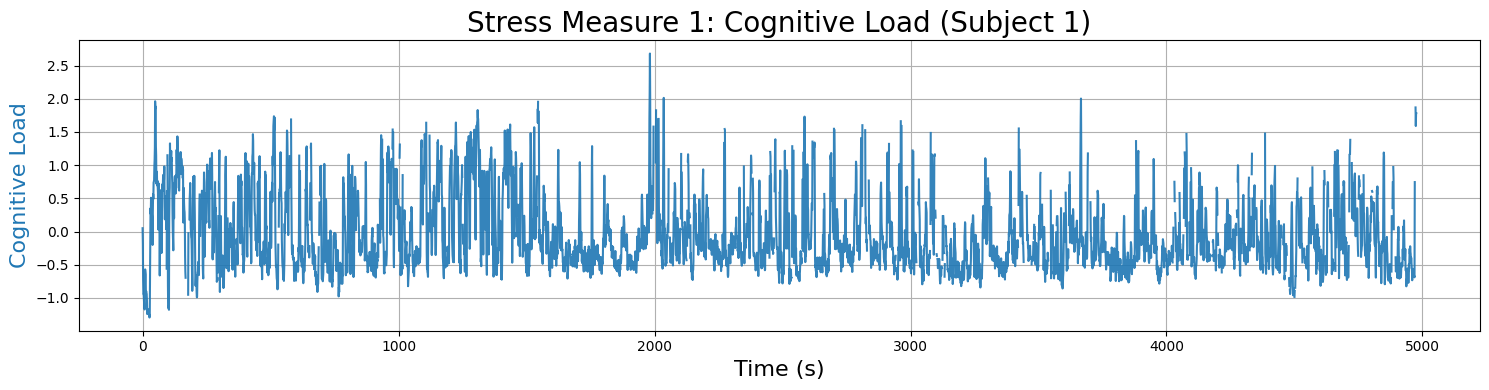

In [37]:
#Stress
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(stress_df['time_sec'], stress_df['cognitive_load'], color='tab:blue', alpha=0.9)
ax.set_ylabel('Cognitive Load', color='tab:blue', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
plt.title('Stress Measure 1: Cognitive Load (Subject 1)', fontsize=20)
plt.grid(True)
fig.tight_layout()

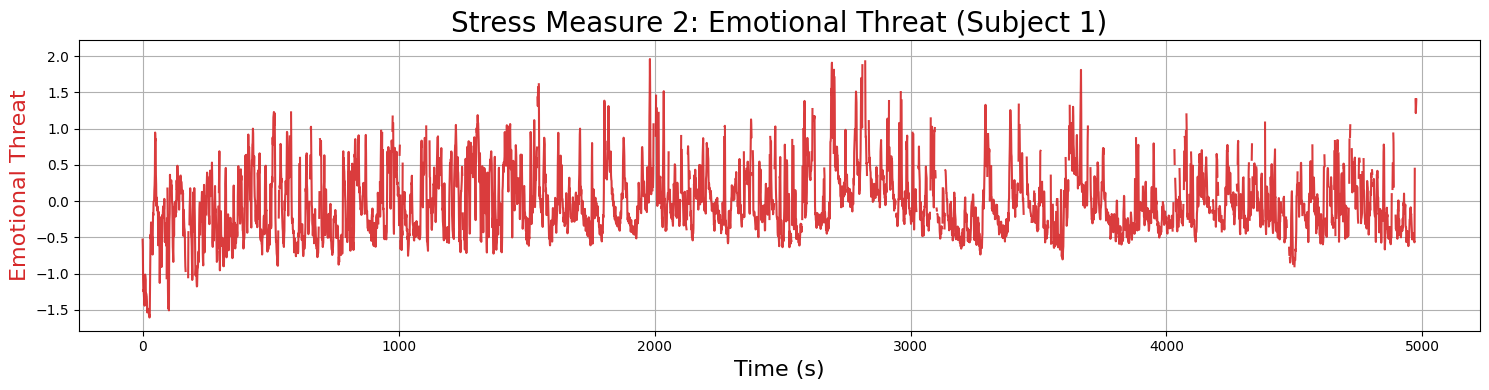

In [36]:
#Stress
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(stress_df['time_sec'], stress_df['emotional_threat'], color='tab:red', alpha=0.9)
ax.set_ylabel('Emotional Threat', color='tab:red', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
plt.title('Stress Measure 2: Emotional Threat (Subject 1)', fontsize=20)
plt.grid(True)
fig.tight_layout()

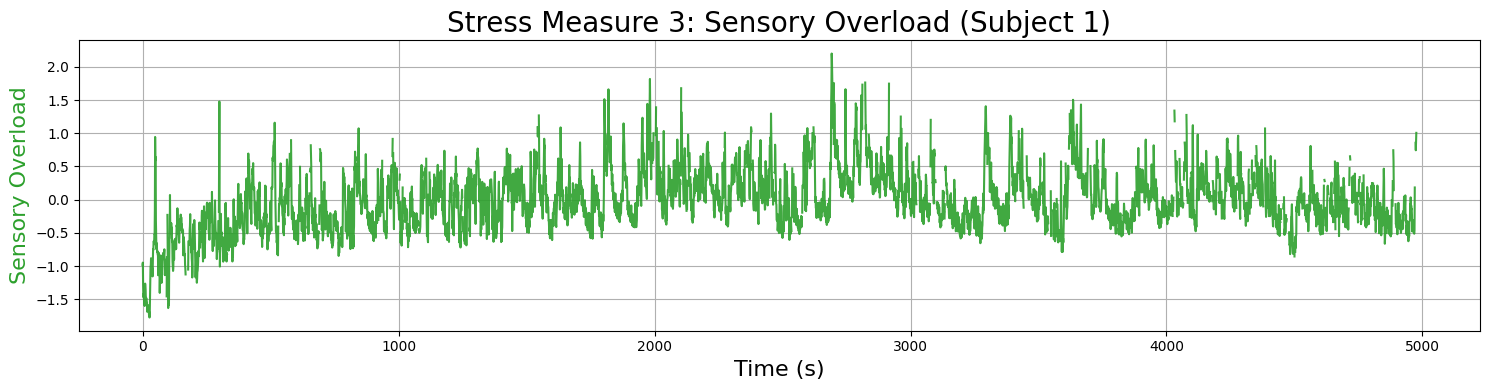

In [38]:
#Stress
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(stress_df['time_sec'], stress_df['sensory_overload'], color='tab:green', alpha=0.9)
ax.set_ylabel('Sensory Overload', color='tab:green', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
plt.title('Stress Measure 3: Sensory Overload (Subject 1)', fontsize=20)
plt.grid(True)
fig.tight_layout()

#### The following are plots to visualize the raw/z-scored Data

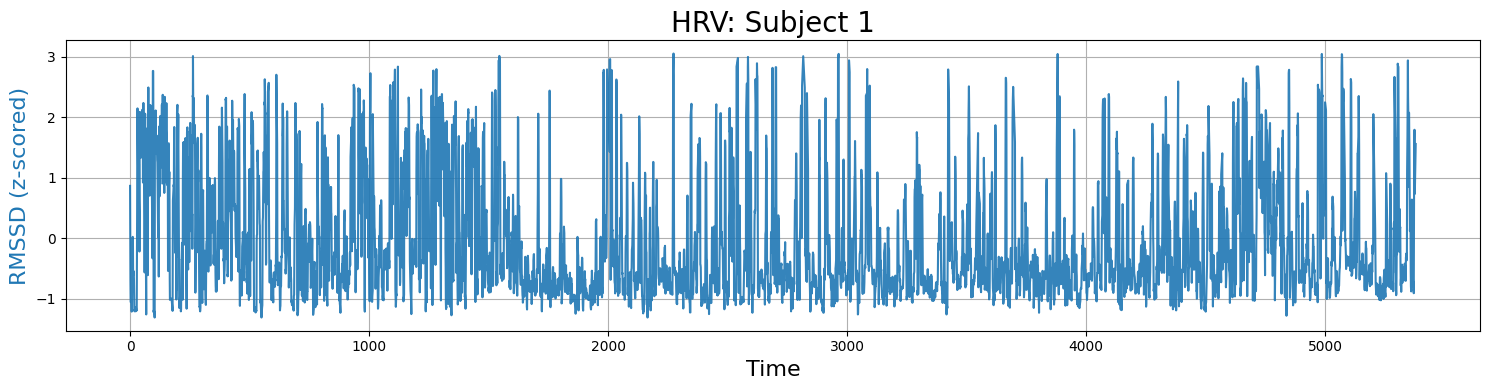

In [37]:
#rmssd
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(hrv_df_clean['elapsed_time'], hrv_df_clean['RMSSD_z'], label='rmssd', color='tab:blue', alpha=0.9)
ax.set_ylabel("RMSSD (z-scored)", color='tab:blue', fontsize=16)
ax.set_xlabel("Time", fontsize=16)
plt.title("HRV: Subject 1", fontsize=20)
plt.grid(True)
fig.tight_layout()

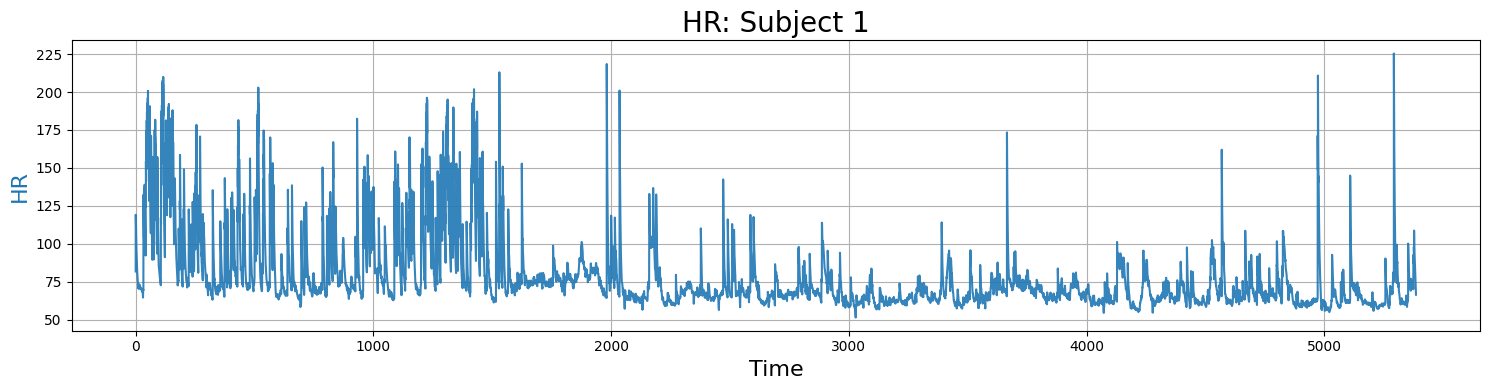

In [38]:
#hr
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(hr_df['elapsed_time'], hr_df['Value'], label='hr', color='tab:blue', alpha=0.9)
ax.set_ylabel("HR", color='tab:blue', fontsize=16)
ax.set_xlabel("Time", fontsize=16)
plt.title("HR: Subject 1", fontsize=20)
plt.grid(True)
fig.tight_layout()

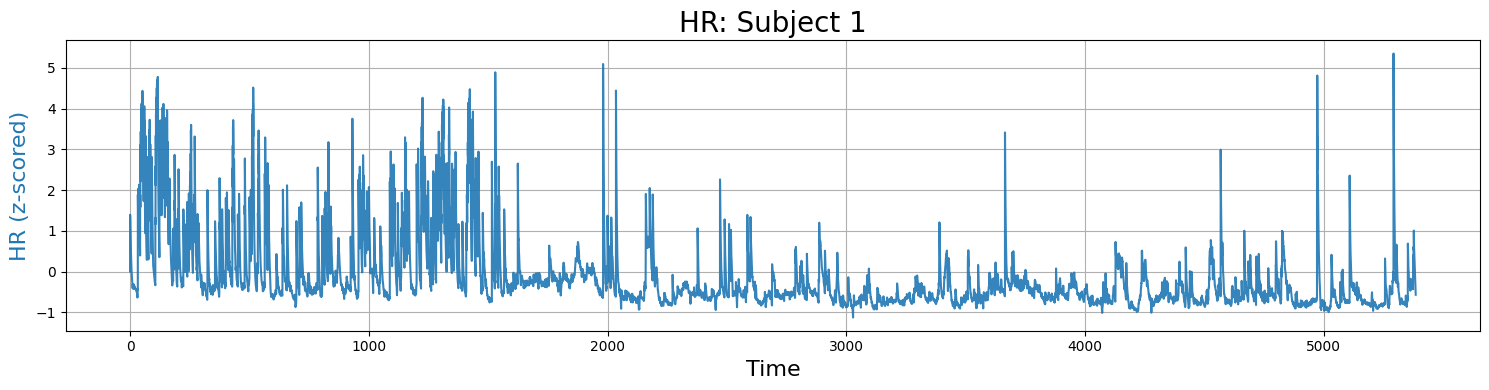

In [39]:
#hr
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(hr_df['elapsed_time'], hr_df['hr_z'], label='hr', color='tab:blue', alpha=0.9)
ax.set_ylabel("HR (z-scored)", color='tab:blue', fontsize=16)
ax.set_xlabel("Time", fontsize=16)
plt.title("HR: Subject 1", fontsize=20)
plt.grid(True)
fig.tight_layout()

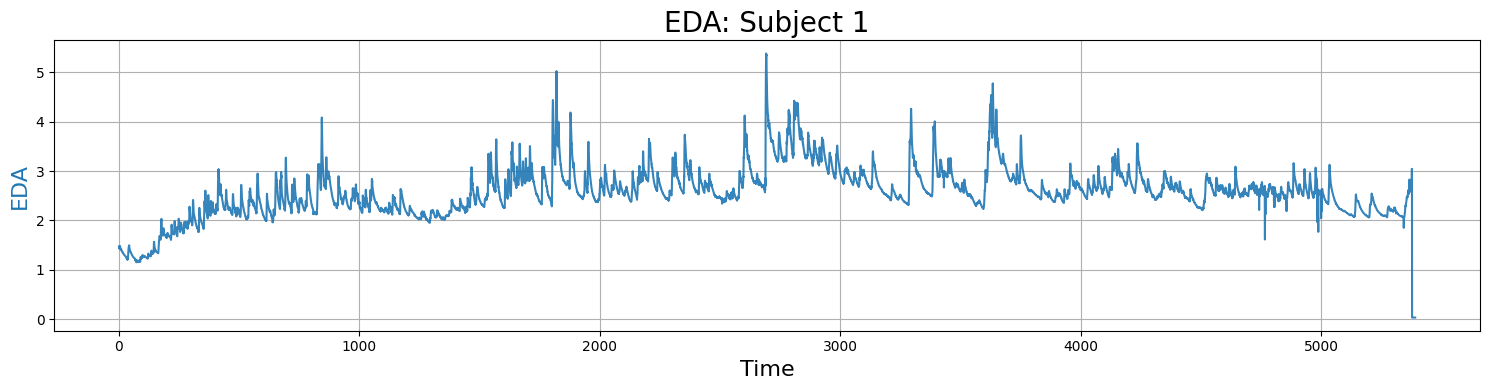

In [40]:
#eda
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(eda_df['elapsed_time'], eda_df['Value'], label='eda', color='tab:blue', alpha=0.9)
ax.set_ylabel("EDA", color='tab:blue', fontsize=16)
ax.set_xlabel("Time", fontsize=16)
plt.title("EDA: Subject 1", fontsize=20)
plt.grid(True)
fig.tight_layout()

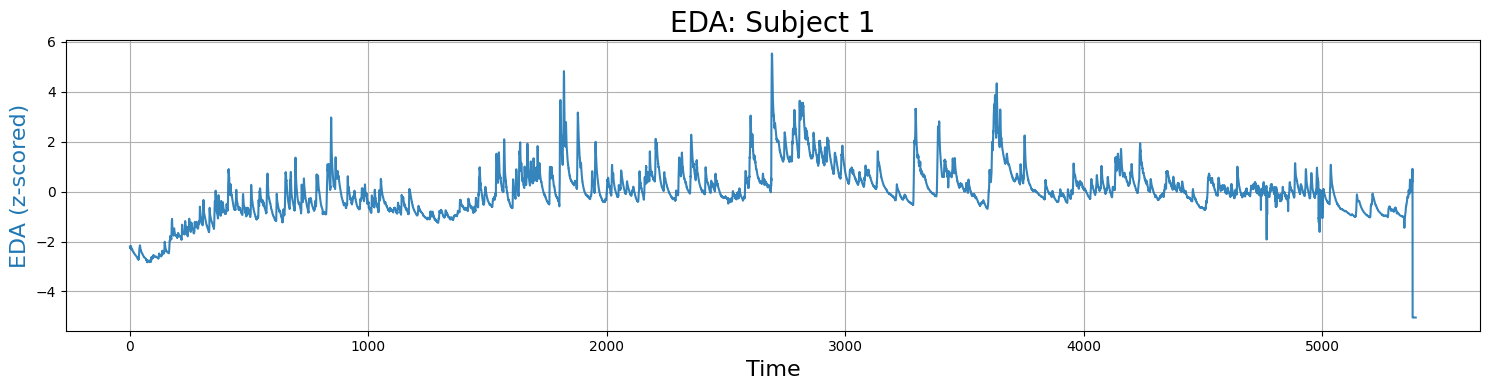

In [41]:
#eda
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(eda_df['elapsed_time'], eda_df['eda_z'], label='eda', color='tab:blue', alpha=0.9)
ax.set_ylabel("EDA (z-scored)", color='tab:blue', fontsize=16)
ax.set_xlabel("Time", fontsize=16)
plt.title("EDA: Subject 1", fontsize=20)
plt.grid(True)
fig.tight_layout()

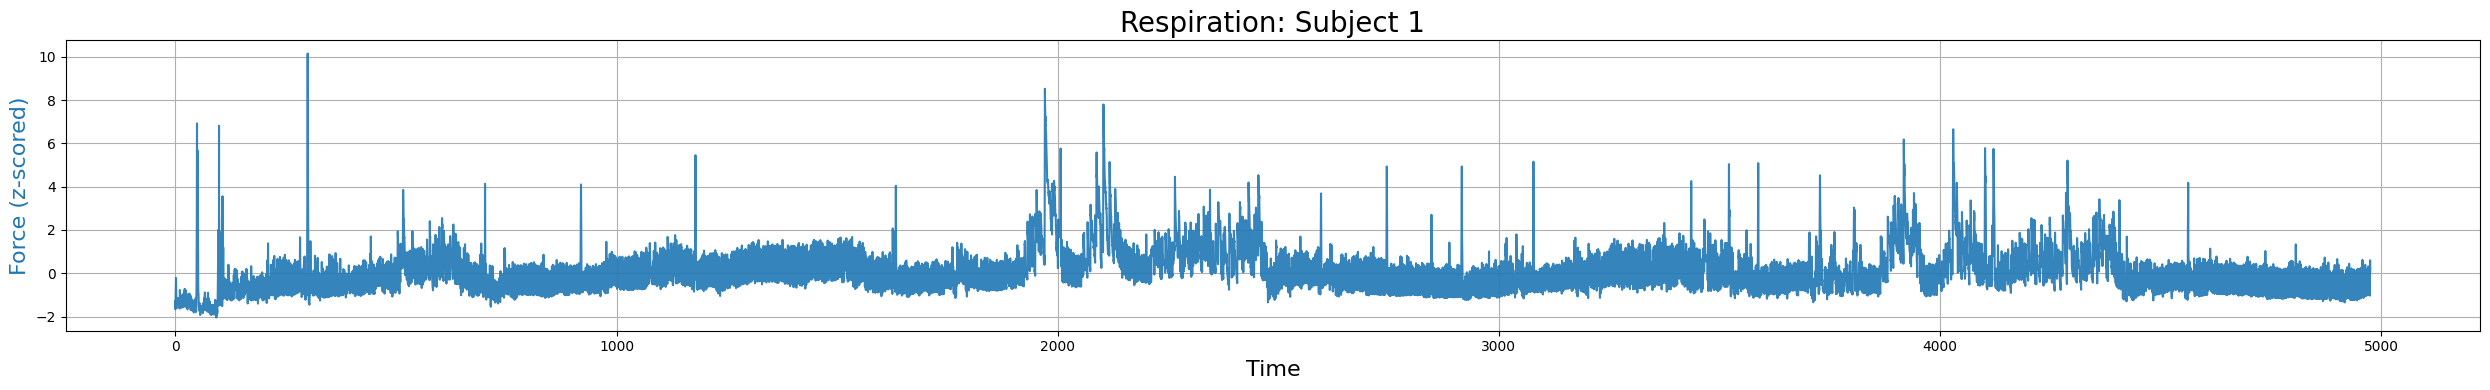

In [42]:
#respiration
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(respiration_df['elapsed_time'], respiration_df['force_z'], label='vernier force', color='tab:blue', alpha=0.9)
ax.set_ylabel("Force (z-scored)", color='tab:blue', fontsize=16)
ax.set_xlabel("Time", fontsize=16)
plt.title("Respiration: Subject 1", fontsize=20)
plt.grid(True)
fig.tight_layout()